#  3/4 discrete optimal transport demo
______________________________________
In this tutorial, you will be taught how to manipulate our toolbox for computing the optimal transport distance between a point cloud and a set of line segments.

## Computation of the of $\frac{3}{4}$-discrete OT
___________________________________________

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from Lag3D import LaguerreTri

np.random.seed(42)

In [2]:
# creation of a spiral shaped polyline
def pointsList2polyline(x):
    pol = np.zeros(tuple([(x.shape[0]-1)*2])+x.shape[1:])
    for i,(deb,fin) in enumerate(zip(x[:-1],x[1:])):
        pol[2*i] = deb
        pol[2*i+1] = fin
        
    return pol

def polyline2pointList(pol):
    x = np.zeros(tuple([pol.shape[0]//2+1])+pol.shape[1:])
    x[:-1] = pol[::2]
    x[-1] = pol[-1]
    return x

b = .1
t = np.linspace(np.pi,6*np.pi,300)
x,y = b*t*np.cos(t),b*t*np.sin(t)
X = np.zeros((x.shape[0],3))
X[:,0]=x
X[:,1]=y

pol = pointsList2polyline(X)

In [3]:
# compute a uniform weight for all line segments
def computeTotalLength(Polyline):
    totalLength = 0.0
    for deb,fin in zip(Polyline[::2],Polyline[1::2]):
        totalLength += np.linalg.norm(deb-fin)
    return totalLength
weightVector = np.ones(pol.shape[0]//2)
weightVector /= computeTotalLength(pol)


In [4]:
# Set measure carried by Diracs as uniform with support 
# corresponding to ones of the polyline measure
nbDiracs = 250
diracPosition = np.zeros((nbDiracs,X.shape[-1]))
axislim = []
for d in range(X.shape[-1]):
    lower,upper = 1.05*np.min(X[:,d]),1.05*np.max(X[:,d])
    axislim.append([lower,upper])
    diracPosition[:,d] = np.random.rand(nbDiracs)*(upper-lower) + lower
    

In [5]:
# instantiate a Laguerre diagram 
L3d = LaguerreTri()
# set Dirac masses positions
L3d.setCoordinates(diracPosition)
# set polyline
L3d.setPolyLineNew(pol,weightVector)

mass,Bar,cost,grad = L3d.compute(np.zeros(nbDiracs))
massDirac = np.ones(nbDiracs)
massDirac /= massDirac.sum()
L3d.setMassDiracs(massDirac)
# Variable for optimization of the Monge Kantorovitch functionnal
gradTol = 5e-5 # numeric tolerance on the gradient
nMaxIter = 4000 # maximum number of iteration
# Wolfe parameters
w1 = .2 
w2 = .9
wMaxIter = 7 # maximum number of inner iteration to determine gradient step
memSize = 250 # memory size of the L-BFGS method
#Launch computation of OT distance
Psiopt, cf, cv,time =L3d.perfomOptimisationBFGS(gradTol,nMaxIter,w1,w2,wMaxIter,memSize)


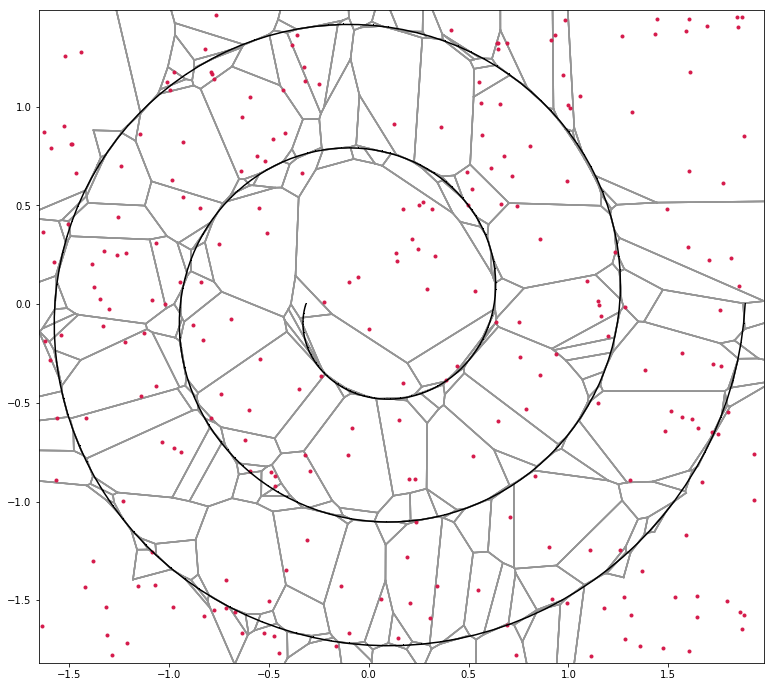

In [6]:
plt.figure(1,figsize=(13,12))
ax = plt.gca()
for i in range(nbDiracs):
    L3d.plotEdges(ax,i,dim=2)

ax.plot(diracPosition[:,0],diracPosition[:,1],marker='.',linewidth=0,c='#D5194A')
ax.plot(x,y,marker=',',c='#000000')
plt.axis([ elm for sublist in axislim[:2] for elm in sublist]);

## Optimization of the polyline position
______________________________
In this section, we make explicit the computation of the gradient. We then perform a gradient descent step to optimize the control points of the polyline.

In [7]:
grad_m,grad_Bar,grad_rho = L3d.derivativePolTotal()
massINIT,costINIT = L3d.computePolyinfo()
cfINIT = np.sum(massINIT + costINIT)
grad_rho = cfINIT*grad_rho/np.tile(weightVector,grad_rho.shape[1]).reshape(grad_rho.shape,order='F')
grad = grad_m + grad_Bar + grad_rho
grad = grad.ravel().reshape(pol.shape)

In [8]:
length = np.linalg.norm(np.diff(X,axis=0),axis=1)
metric = np.zeros(length.size + 1)
metric[1:-1] = .5*(length[1:] + length[:-1])
metric[0],metric[-1] = length[0],length[-1]
M = pointsList2polyline(metric)
M = np.tile(M,grad.shape[1]).reshape(grad.shape,order='F')

In [9]:
#apply gradient step
pol -= grad*1./M

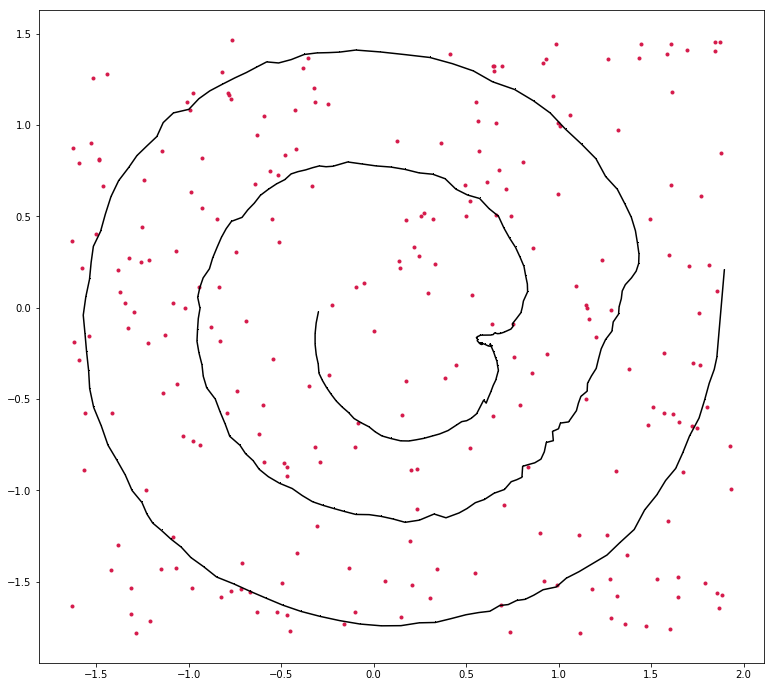

In [10]:
X = polyline2pointList(pol)
plt.figure(1,figsize=(13,12));
plt.plot(diracPosition[:,0],diracPosition[:,1],marker='.',linewidth=0,c='#D5194A')
plt.plot(X[:,0],X[:,1],marker=',',c='#000000');

## Optimization of line position
________________

The optimization of line position proceeds as follow: first, compute the optimal distance between the point cloud and the polyline (i.e. measure carried by line segments), then optimize the polyline position by a gradient iteration with the metric $\textbf{M}$ described in [our paper](https://arxiv.org/abs/1806.09537).

The results are depicted in the following Figure, the most recent iterations are the plotted in green.

Norm of the gradient at last iteration 5.9253e-03


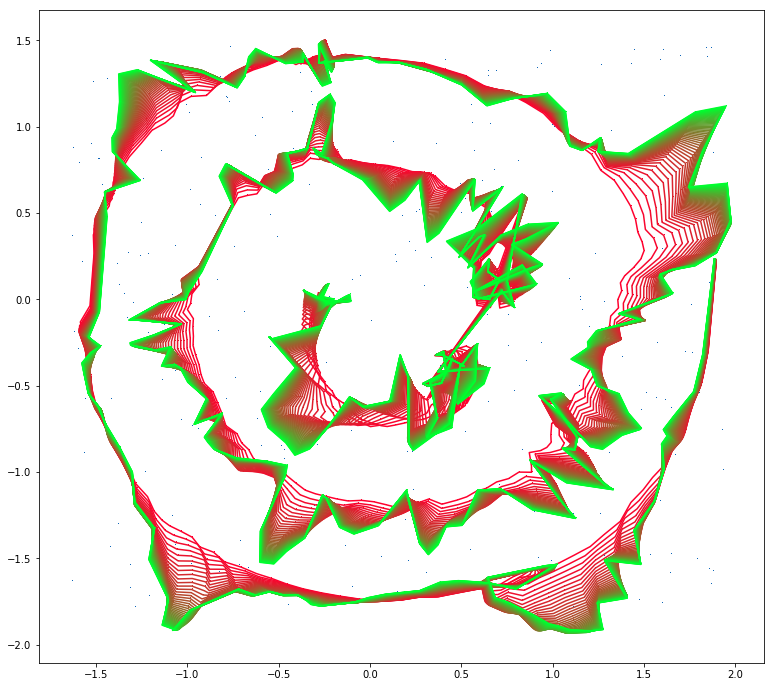

In [11]:
# with several steps
plt.figure(1,figsize=(13,12))
plt.plot(diracPosition[:,0],diracPosition[:,1],marker=',',linewidth=0,c='#0E66B9')
nbiter = 50
rscal = np.array(np.flip(np.linspace(0,255,nbiter)),dtype=int)
gscal= np.array(np.linspace(0,255,nbiter),dtype=int)
colscal = ["#"+hex(r).split('x')[-1].zfill(2)+hex(g).split('x')[-1].zfill(2)+'2e' for r,g in zip(rscal,gscal)]
for i in range(nbiter):   
    weightVector = np.ones(pol.shape[0]//2)
    weightVector /= computeTotalLength(pol)
    L3d.setPolyLineNew(pol,weightVector)
    Psiopt, cf, cv,time =L3d.perfomOptimisationBFGS(gradTol,nMaxIter,w1,w2,wMaxIter,memSize)
    grad_m,grad_Bar,grad_rho = L3d.derivativePolTotal()
    massINIT,costINIT = L3d.computePolyinfo()
    cfINIT = np.sum(massINIT + costINIT)
    grad_rho = cfINIT*grad_rho/np.tile(weightVector,grad_rho.shape[1]).reshape(grad_rho.shape,order='F')
    grad = grad_m + grad_Bar + grad_rho
    grad = grad.ravel().reshape(pol.shape)
    length = np.linalg.norm(np.diff(X,axis=0),axis=1)
    metric = np.zeros(length.size + 1)
    metric[1:-1] = .5*(length[1:] + length[:-1])
    metric[0],metric[-1] = length[0],length[-1]
    M = pointsList2polyline(metric)
    M = np.tile(M,grad.shape[1]).reshape(grad.shape,order='F')
    pol -= grad*1./M
    X = polyline2pointList(pol)
    plt.plot(X[:,0],X[:,1],marker=',',c=colscal[i])
    
print("Norm of the gradient at last iteration {:.4e}".format(np.linalg.norm(grad)))

Note first that there are no theoretical guarantees for this algorithm to converge towards the global solution. We empirically observe that it often gets stuck in local minima for a **small** number of Dirac masses.

Moreover, the resulting polyline is very scribbled, and in practice unusable for concrete application namely: MRI trajectory design or trajectory for wood engraving.

To bypass this problem, we now present an alternative direction gradient descent that encompasses the projection of the polyline over a set of admissible constraints.

## $\frac{3}{4}$-discrete curvling

In order to get a cinematically admissible curve one should define sets of constraints and corresponding projectors as described [in](https://arxiv.org/abs/1804.08356).

In a nutshell, this method consists in computing the discrete derivatives of the polyline (with discrete finite elements operators), and if their norms are above a certain threshold we project the polyline back to the admissible set of polylines with a bounded speed and curvature via an ADMM algorithm.

In [12]:
from Admm import admm,proj_inf_2,mat_deriv,mat_deriv2,verif_inf_2
import scipy.sparse as sps

xflat = polyline2pointList(pol)
nn = x.shape[0]
projectors=[proj_inf_2,proj_inf_2]
verificators=[verif_inf_2,verif_inf_2]
multipliers=[1./2.,1./4.]
alpha1,alpha2 = 42,.06
bounds=[alpha1,alpha2]
matrices=[mat_deriv(nn),mat_deriv2(nn)]
Admm=admm((nn,2),matrices,projectors,multipliers,metric=sps.eye(nn),verificators=verificators,solver='factorize')
xflat = xflat[:,:2]
xold = np.copy(xflat)
xflat,res = Admm.solve(xflat,bounds,nitermax=2000,xInit=xflat,tol=1.e-5,verbose=1)

######### niter :  992 CONVERGENCE --- distance : 1.42e+00 --- Lagrange :9.99e-06 ---- x :1.53e-07 [7.36e-01,1.00e+02]##########


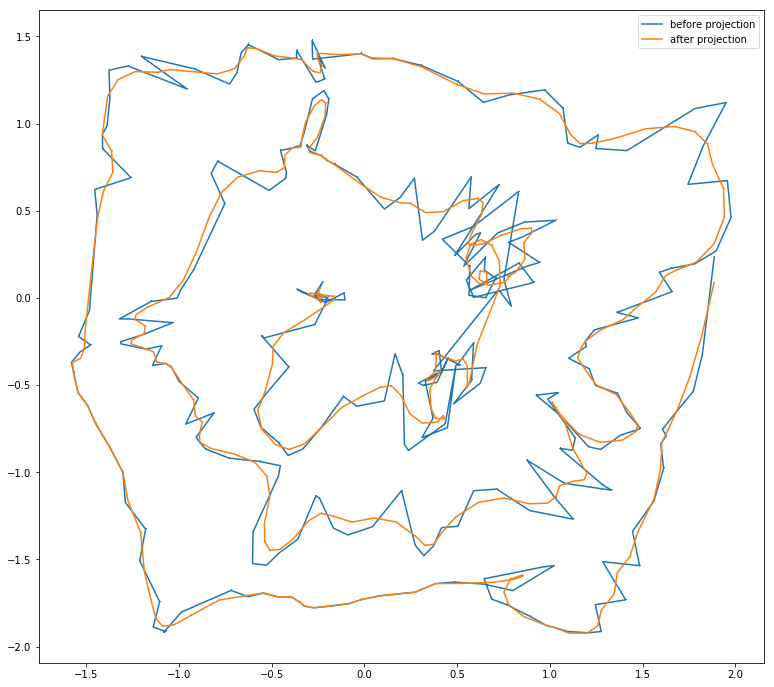

In [13]:
plt.figure(1,figsize=(13,12))
plt.plot(xold[:,0],xold[:,1],marker=',')
plt.plot(xflat[:,0],xflat[:,1],marker=',')
plt.legend(["before projection","after projection"]);

In the previous example, we reduce the curvature of the given curve (controlled by the parameter $\alpha_2$). Similarly, we can shrink the curve by reducing the value of the parameter $\alpha_1$.

######### niter :   71 CONVERGENCE --- distance : 7.21e-01 --- Lagrange :9.89e-06 ---- x :1.83e-07 [1.00e+02,9.50e-01]##########


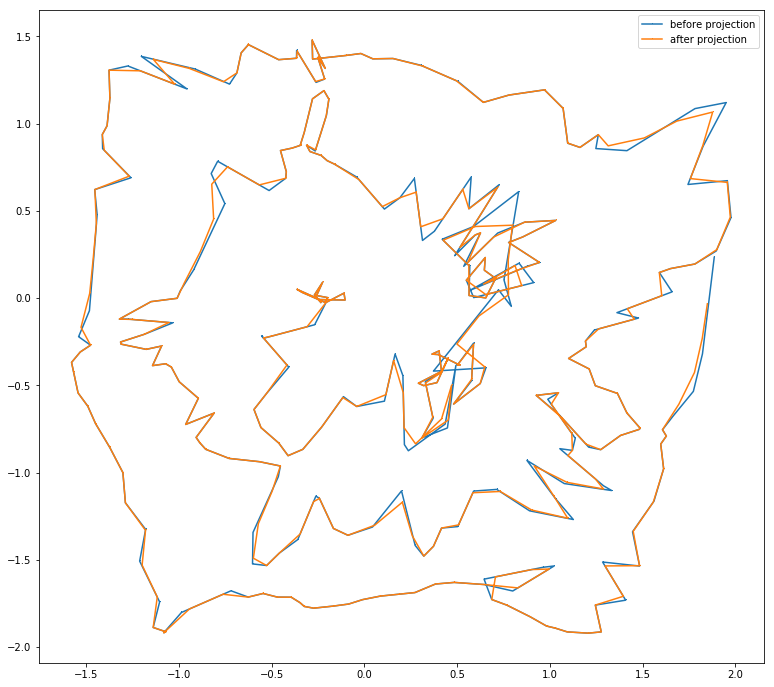

In [14]:
from Admm import admm,proj_inf_2,mat_deriv,mat_deriv2,verif_inf_2
import scipy.sparse as sps

xflat = polyline2pointList(pol)
nn = xflat.shape[0]
projectors=[proj_inf_2,proj_inf_2]
verificators=[verif_inf_2,verif_inf_2]
multipliers=[1./2.,1./4.]
alpha1,alpha2 = .2,42
bounds=[alpha1,alpha2]
matrices=[mat_deriv(nn),mat_deriv2(nn)]
Admm=admm((nn,2),matrices,projectors,multipliers,metric=sps.eye(nn),verificators=verificators,solver='factorize')
xflat = xflat[:,:2]
xold = np.copy(xflat)
xflat,res = Admm.solve(xflat,bounds,nitermax=2000,xInit=xflat,tol=1.e-5,verbose=1)
plt.figure(1,figsize=(13,12))
plt.plot(xold[:,0],xold[:,1],marker=',')
plt.plot(xflat[:,0],xflat[:,1],marker=',')
plt.legend(["before projection","after projection"]);

## $\frac{3}{4}$-discrete algorithm with polyline length and curvature constraints
____________________________
Wrapping up the two previous algorithms together we obtain the *curvature* and *length* controlled polyline optimization algorithm.

+ Initial curve (below)

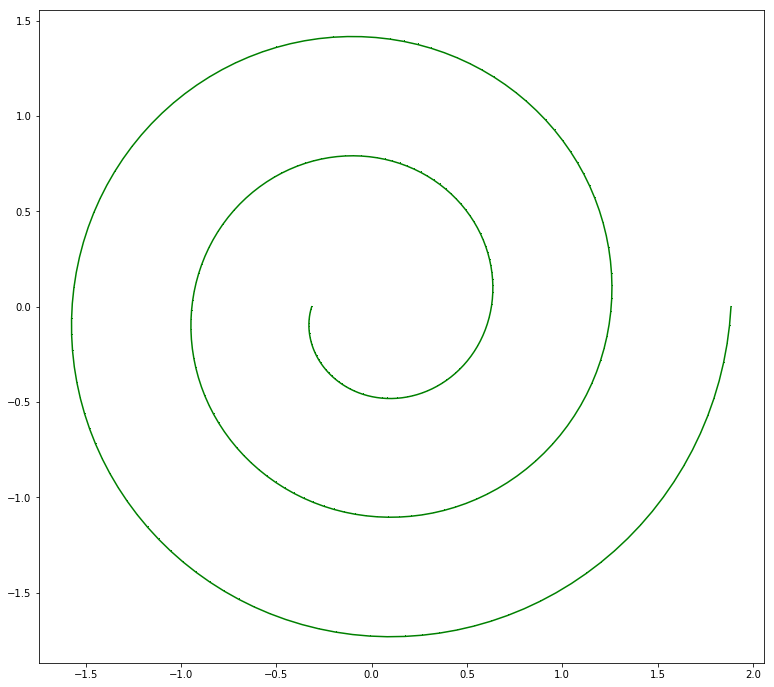

In [15]:
b = .1
t = np.linspace(np.pi,6*np.pi,300)
x,y = b*t*np.cos(t),b*t*np.sin(t)
X = np.zeros((x.shape[0],3))
X[:,0]=x
X[:,1]=y

pol = pointsList2polyline(X)

plt.figure(1,figsize=(13,12))
plt.plot(X[:,0],X[:,1],marker=',',c='g')
plt.axis("equal");

Norm of the gradient at last iteration 5.0834e-02


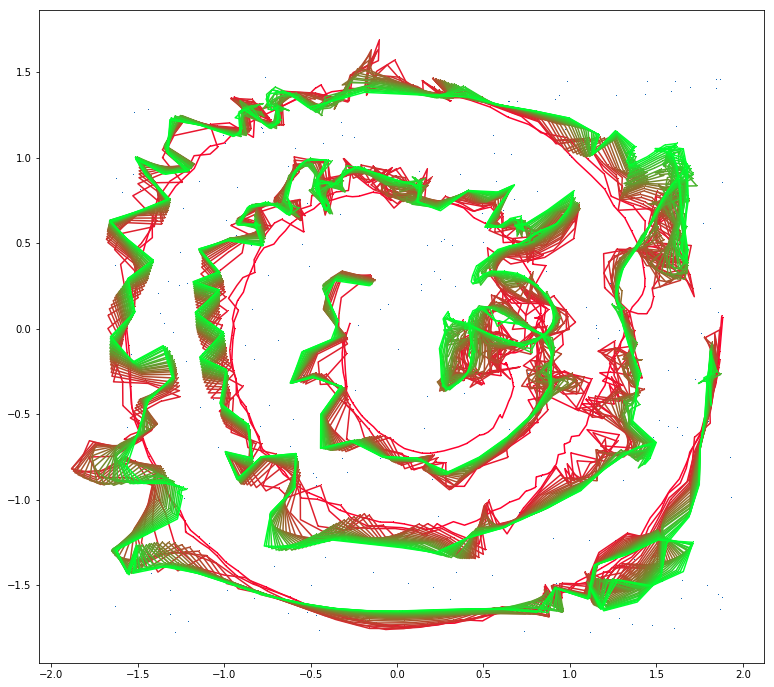

In [16]:
alpha1,alpha2 = .2,.3

plt.figure(1,figsize=(13,12))
plt.plot(diracPosition[:,0],diracPosition[:,1],marker=',',linewidth=0,c='#0E66B9')
nbiter = 25
rscal = np.array(np.flip(np.linspace(0,255,nbiter)),dtype=int)
gscal= np.array(np.linspace(0,255,nbiter),dtype=int)
colscal = ["#"+hex(r).split('x')[-1].zfill(2)+hex(g).split('x')[-1].zfill(2)+'2e' for r,g in zip(rscal,gscal)]
for i in range(nbiter):   
    weightVector = np.ones(pol.shape[0]//2)
    weightVector /= computeTotalLength(pol)
    L3d.setPolyLineNew(pol,weightVector)
    Psiopt, cf, cv,time =L3d.perfomOptimisationBFGS(gradTol,nMaxIter,w1,w2,wMaxIter,memSize)
    grad_m,grad_Bar,grad_rho = L3d.derivativePolTotal()
    massINIT,costINIT = L3d.computePolyinfo()
    cfINIT = np.sum(massINIT + costINIT)
    grad_rho = cfINIT*grad_rho/np.tile(weightVector,grad_rho.shape[1]).reshape(grad_rho.shape,order='F')
    grad = grad_m + grad_Bar + grad_rho
    grad = grad.ravel().reshape(pol.shape)
    length = np.linalg.norm(np.diff(X,axis=0),axis=1)
    metric = np.zeros(length.size + 1)
    metric[1:-1] = .5*(length[1:] + length[:-1])
    metric[0],metric[-1] = length[0],length[-1]
    M = pointsList2polyline(metric)
    M = np.tile(M,grad.shape[1]).reshape(grad.shape,order='F')
    pol -= grad*1./M
    xflat = polyline2pointList(pol)
    nn = xflat.shape[0]
    projectors=[proj_inf_2,proj_inf_2]
    verificators=[verif_inf_2,verif_inf_2]
    multipliers=[1./2.,1./4.]
    bounds=[alpha1,alpha2]
    matrices=[mat_deriv(nn),mat_deriv2(nn)]
    Admm=admm((nn,2),matrices,projectors,multipliers,metric=sps.eye(nn),verificators=verificators,solver='factorize')
    xflat = xflat[:,:2]
    xflat,res = Admm.solve(xflat,bounds,nitermax=500,xInit=xflat,tol=1.e-5,verbose=0)
    X = np.zeros((xflat.shape[0],3))
    X[:,:2]= xflat
    plt.plot(X[:,0],X[:,1],marker=',',c=colscal[i])
    pol = pointsList2polyline(X)
    
print("Norm of the gradient at last iteration {:.4e}".format(np.linalg.norm(grad)))

## A natural multiscale procedure
------------------
The previously presented algorithm is trivially implementable in a multi-scale way. In the following, we provide the code that allows multiplying the number of discretization points of the polyline by a factor 2.

In [17]:
def upSampleByTwo(x):
    xRes = np.zeros((2*x.shape[0],x.shape[1]))
    n = x.shape[0]
    for i in xrange(x.shape[0]-1):
        xRes[2*i,:] = x[i,:]
        d=np.array([[x[i+1,1]-x[i,1]],[x[i,0]-x[i+1,0]]])
        xRes[2*i+1,:] = .5*(x[i,:]+x[i+1,:])+1.e-2*(2*np.random.rand(1)-1)*np.squeeze(d)
    xRes[-2,:] = x[-1,:]
    xRes[-1,:] = (x[-1,:] + x[0,:])*.5
    return xRes